# 🏦 Robo-Advisor - Portfolio Optimization Demo

**Démonstration complète de la plateforme d'optimisation de portefeuille**

Ce notebook présente:
1. **Optimisation Markowitz** (Mean-Variance)
2. **Risk Parity** (Équilibrage des risques)
3. **CVaR Optimization** (Minimisation des pertes extrêmes)
4. **Backtesting** comparatif
5. **Risk Metrics** (VaR, Sharpe, Sortino)

---

## 📦 Setup & Imports

In [1]:
# Imports standards
import sys
import warnings
warnings.filterwarnings('ignore')

# Add project to path
sys.path.append('..')

# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuration
sns.set_theme(style="darkgrid")
#plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Our modules
#from src.infrastructure.optimization.portfolio_optimizer import GurobiOptimizer
from src.infrastructure.optimization.solver_factory import SolverFactory, create_optimizer
from src.infrastructure.risk_management.risk_calculator import RiskCalculator, StressTester
from src.infrastructure.ml.evaluation.financial_metrics import (
    calculate_sharpe_ratio,
    calculate_sortino_ratio,
    calculate_calmar_ratio
)

print(" Imports réussis!")

 Imports réussis!


## 1. Chargement des Données

Nous allons utiliser un portefeuille diversifié de **10 actions** de différents secteurs.

In [6]:
# Portfolio de 10 actions diversifiées
tickers = [
    'AAPL',  # Tech - Apple
    'MSFT',  # Tech - Microsoft
    'JPM',   # Finance - JPMorgan
    'JNJ',   # Healthcare - Johnson & Johnson
    'XOM',   # Energy - Exxon Mobil
    'PG',    # Consumer - Procter & Gamble
    'DIS',   # Entertainment - Disney
    'BA',    # Industrials - Boeing
    #'GOOGL', # Tech - Google
    #'WMT'    # Retail - Walmart
]

# Période d'analyse
start_date = '2020-01-01'
end_date = '2024-01-01'

print(f"Portfolio: {len(tickers)} actifs")
print(f"Période: {start_date} à {end_date}")

Portfolio: 8 actifs
Période: 2020-01-01 à 2024-01-01


In [9]:
# Téléchargement des données (yfinance)
import yfinance as yf
print(" Téléchargement des données...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']

# Calcul des rendements
returns = data.pct_change().dropna()

print(f" {len(data)} jours de données chargés")
print(f" {len(returns)} rendements quotidiens calculés")

# Aperçu
data.tail()


 Téléchargement des données...


Failed to get ticker 'AAPL' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'DIS' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JPM' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JNJ' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'WMT' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'BA' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'MSFT' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JNJ' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'AAPL' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JPM' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'DIS' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'BA' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'WMT' reason: Expecting value: line 1 column 1 (char 0

ValueError: attempt to get argmax of an empty sequence

Failed to get ticker 'PG' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JNJ' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'AAPL' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JPM' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'DIS' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'BA' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'XOM' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'MSFT' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'PG' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'XOM' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JNJ' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'AAPL' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JPM' reason: Expecting value: line 1 column 1 (char 0)

In [12]:
import pandas as pd
import os

# Portfolio de 8 actions diversifiées
tickers = [
    'AAPL',  # Tech - Apple
    'MSFT',  # Tech - Microsoft
    'JPM',   # Finance - JPMorgan
    'JNJ',   # Healthcare - Johnson & Johnson
    'XOM',   # Energy - Exxon Mobil
    'PG',    # Consumer - Procter & Gamble
    'DIS',   # Entertainment - Disney
    'BA',    # Industrials - Boeing
]

# Période d'analyse
start_date = '2020-01-01'
end_date = '2024-01-01'

# Dossier où vous avez enregistré les CSVs téléchargés depuis Stooq
data_folder = "data"

# Chargement des données depuis les CSVs
frames = []
for t in tickers:
    file_path = os.path.join(data_folder, f"{t}.csv")
    df = pd.read_csv(file_path, parse_dates=["Date"])
    # Filtrer la période choisie
    df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    # Mettre Date en index et ne garder que la colonne "Close"
    df = df.set_index("Date")[["Close"]].rename(columns={"Close": t})
    frames.append(df)

# Fusionner toutes les actions en un seul DataFrame
data = pd.concat(frames, axis=1).sort_index()

# Calcul des rendements quotidiens
returns = data.pct_change().dropna()

print(f" {len(data)} jours de données chargés")
print(f" {len(returns)} rendements quotidiens calculés")

# Aperçu
data.tail()


 1006 jours de données chargés
 1005 rendements quotidiens calculés


,AAPL,MSFT,JPM,JNJ,XOM,PG,DIS,BA
Date,,,,,,,,
2023-12-22,191.788,371.801,167.40,155.46,101.91,145.28,91.02,260.44
2023-12-26,191.245,371.879,168.39,156.14,102.14,145.94,90.95,262.79
2023-12-27,191.345,371.294,169.40,156.35,101.66,146.06,90.38,262.10
2023-12-28,191.768,372.494,170.30,156.58,100.19,145.73,90.40,260.35
2023-12-29,190.729,373.249,170.10,156.74,99.98,146.54,90.29,260.66


###  Visualisation des Prix Historiques

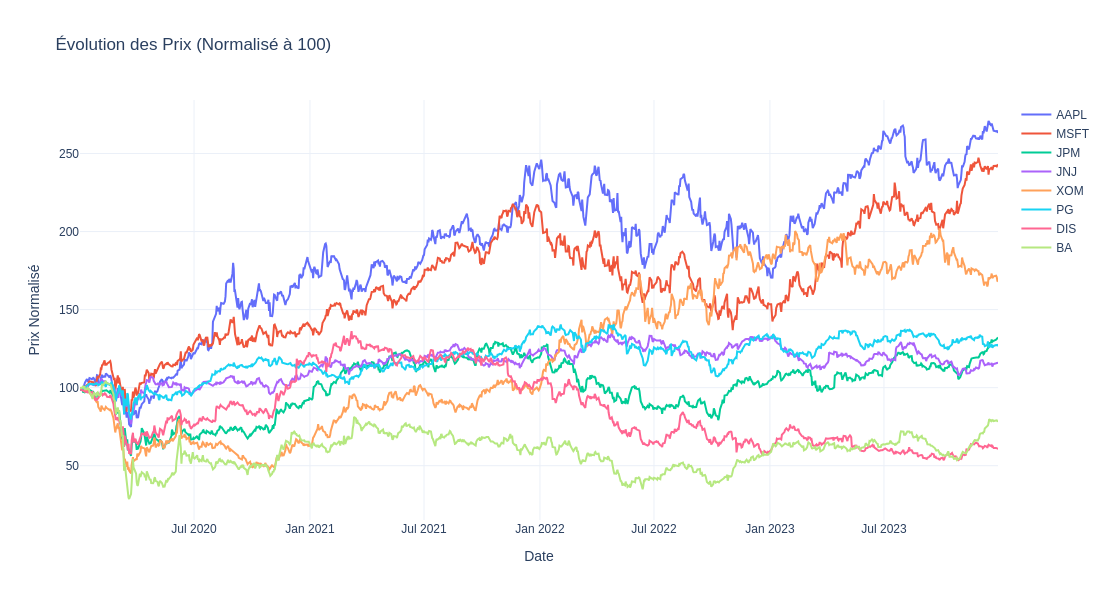

In [13]:
# Normaliser les prix à 100 pour comparaison
normalized_prices = (data / data.iloc[0]) * 100

# Plotly interactive chart
fig = go.Figure()

for ticker in tickers:
    fig.add_trace(go.Scatter(
        x=normalized_prices.index,
        y=normalized_prices[ticker],
        mode='lines',
        name=ticker,
        hovertemplate='<b>%{fullData.name}</b><br>Date: %{x}<br>Prix: %{y:.2f}<extra></extra>'
    ))

fig.update_layout(
    title=' Évolution des Prix (Normalisé à 100)',
    xaxis_title='Date',
    yaxis_title='Prix Normalisé',
    hovermode='x unified',
    height=600,
    template='plotly_white'
)

fig.show()

###  Statistiques Descriptives

In [14]:
# Calcul des statistiques annualisées
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
sharpe_ratios = annual_returns / annual_volatility

stats_df = pd.DataFrame({
    'Rendement Annuel (%)': (annual_returns * 100).round(2),
    'Volatilité Annuelle (%)': (annual_volatility * 100).round(2),
    'Sharpe Ratio': sharpe_ratios.round(2)
}).sort_values('Sharpe Ratio', ascending=False)

print(" Statistiques par Actif (2020-2024)")
print("="*60)
stats_df

 Statistiques par Actif (2020-2024)


,Rendement Annuel (%),Volatilité Annuelle (%),Sharpe Ratio
AAPL,29.90,33.56,0.89
MSFT,27.59,32.61,0.85
XOM,19.95,37.25,0.54
PG,8.61,22.19,0.39
JPM,12.89,34.43,0.37
JNJ,5.85,20.63,0.28
BA,8.84,54.49,0.16
DIS,-6.06,35.71,-0.17


In [15]:
# Visualisation Rendement vs Volatilité
fig = px.scatter(
    x=annual_volatility * 100,
    y=annual_returns * 100,
    text=stats_df.index,
    color=sharpe_ratios,
    size=sharpe_ratios,
    color_continuous_scale='RdYlGn',
    labels={'x': 'Volatilité Annuelle (%)', 'y': 'Rendement Annuel (%)', 'color': 'Sharpe Ratio'},
    title='Rendement vs Volatilité (Taille = Sharpe Ratio)'
)

fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(height=600, template='plotly_white')
fig.show()

ValueError: 
    Invalid element(s) received for the 'size' property of scatter.marker
        Invalid elements include: [-0.16973560786228709]

    The 'size' property is a number and may be specified as:
      - An int or float in the interval [0, inf]
      - A tuple, list, or one-dimensional numpy array of the above

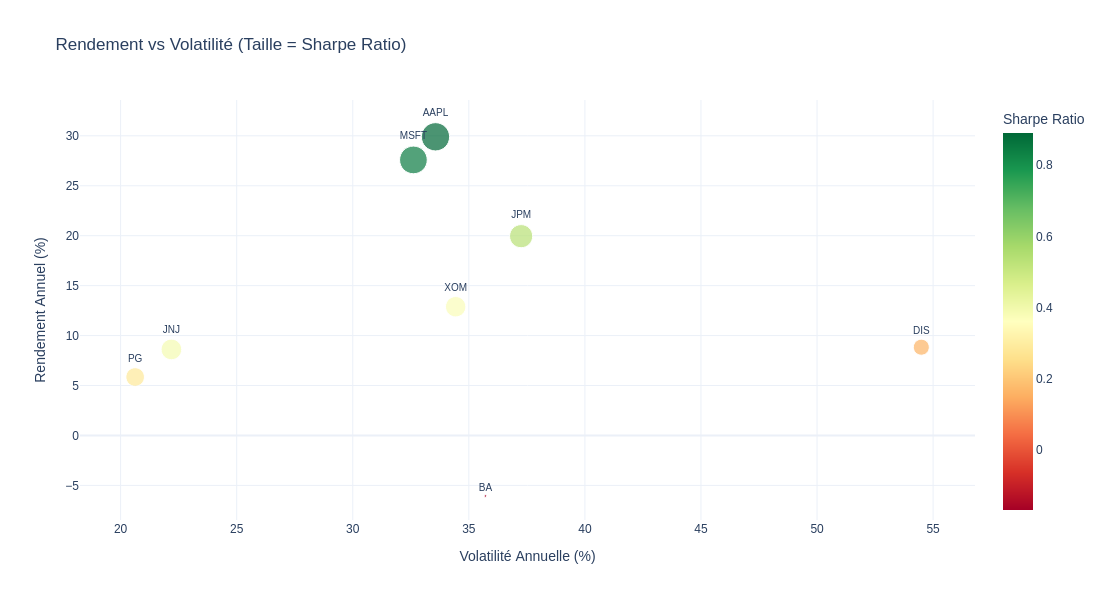

In [16]:
import numpy as np
import plotly.express as px

# --- Make sure marker sizes are all positive ---
# Shift Sharpe ratios so that the smallest value is slightly above 0
size = sharpe_ratios - np.min(sharpe_ratios) + 0.01

# Scatter plot: Volatility vs Return, marker size = Sharpe ratio
fig = px.scatter(
    x=annual_volatility * 100,
    y=annual_returns * 100,
    text=stats_df.index,
    color=sharpe_ratios,
    size=size,
    color_continuous_scale='RdYlGn',
    labels={
        'x': 'Volatilité Annuelle (%)',
        'y': 'Rendement Annuel (%)',
        'color': 'Sharpe Ratio'
    },
    title='Rendement vs Volatilité (Taille = Sharpe Ratio)'
)

fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(height=600, template='plotly_white')

fig.show()


###  Matrice de Corrélation

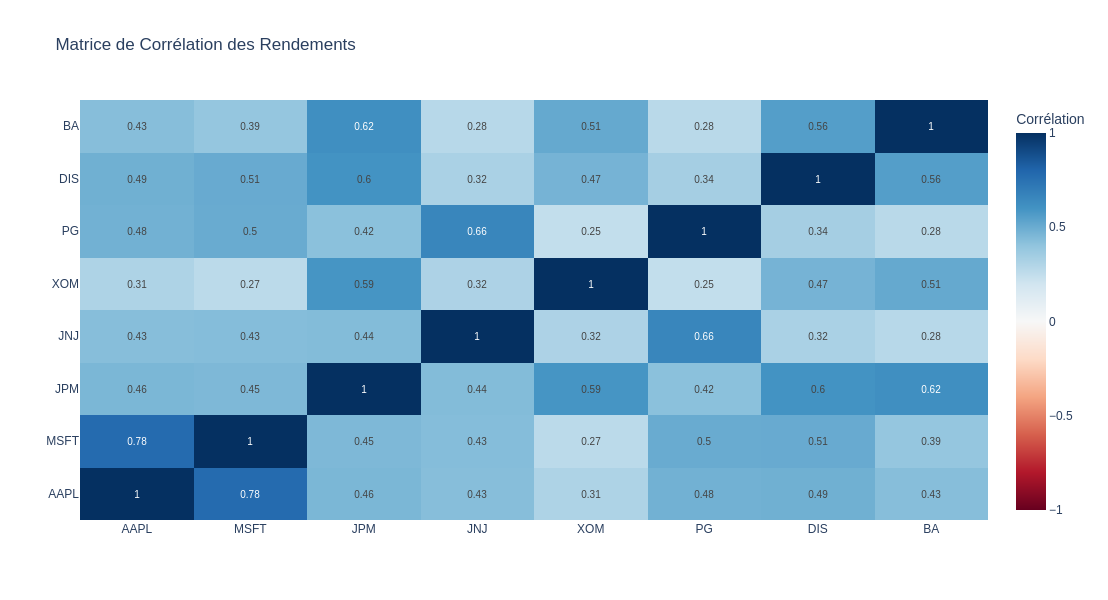


 Observations:
   - Corrélation moyenne: 0.45
   - Paire la plus corrélée: ('MSFT', 'AAPL')


In [17]:
# Calcul de la corrélation
correlation_matrix = returns.corr()

# Heatmap avec Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='RdBu',
    zmid=0,
    text=correlation_matrix.values.round(2),
    texttemplate='%{text}',
    textfont={"size": 10},
    colorbar=dict(title="Corrélation")
))

fig.update_layout(
    title=' Matrice de Corrélation des Rendements',
    height=600,
    template='plotly_white'
)

fig.show()

print("\n Observations:")
print(f"   - Corrélation moyenne: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.2f}")
print(f"   - Paire la plus corrélée: {correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates().index[1]}")

## 2. Optimisation de Portefeuille

Nous allons comparer **3 stratégies d'optimisation**:
1. **Markowitz** (Mean-Variance) - Maximise le Sharpe Ratio
2. **Risk Parity** - Équilibre les contributions au risque
3. **CVaR** - Minimise les pertes extrêmes (95% confidence)

In [18]:
# Préparation des inputs pour l'optimisation
expected_returns = returns.mean() * 252  # Annualisé
cov_matrix = returns.cov() * 252  # Annualisé
risk_free_rate = 0.02  # 2% taux sans risque

print("Inputs pour l'optimisation:")
print(f"   - Rendements espérés: {expected_returns.min():.2%} à {expected_returns.max():.2%}")
print(f"   - Volatilité moyenne: {np.sqrt(np.diag(cov_matrix)).mean():.2%}")
print(f"   - Taux sans risque: {risk_free_rate:.2%}")

Inputs pour l'optimisation:
   - Rendements espérés: -6.06% à 29.90%
   - Volatilité moyenne: 33.86%
   - Taux sans risque: 2.00%


### Stratégie 1: Markowitz (Mean-Variance)

In [21]:
# Initialize optimizer
optimizer = create_optimizer('highs')

# Markowitz optimization
print(" Optimisation Markowitz en cours...")
markowitz_result = optimizer.optimize_markowitz(
    expected_returns=expected_returns,
    cov_matrix=cov_matrix,
    risk_free_rate=risk_free_rate,
    constraints={
        'max_position_size': 0.40,  # Max 40% sur un actif
        'min_position_size': 0.01   # Min 1% si investi
    }
)

if markowitz_result.success:
    print("Optimisation Markowitz réussie!")
    markowitz_weights = pd.Series(markowitz_result.weights)
    markowitz_weights = markowitz_weights[markowitz_weights > 0.001].sort_values(ascending=False)
    
    print("\nAllocation Markowitz:")
    for asset, weight in markowitz_weights.items():
        print(f"   {asset}: {weight:.1%}")
    
    print(f"\n Rendement espéré: {markowitz_result.expected_return:.2%}")
    print(f" Volatilité: {markowitz_result.volatility:.2%}")
    print(f" Sharpe Ratio: {markowitz_result.sharpe_ratio:.2f}")
else:
    print("❌ Optimisation échouée")

 Optimisation Markowitz en cours...
Optimisation Markowitz réussie!

Allocation Markowitz:
   AAPL: 40.0%
   MSFT: 40.0%
   XOM: 15.0%
   JNJ: 1.0%
   JPM: 1.0%
   PG: 1.0%
   DIS: 1.0%
   BA: 1.0%

 Rendement espéré: 26.29%
 Volatilité: 28.10%
 Sharpe Ratio: 0.86


###  Stratégie 2: Risk Parity

In [22]:
print(" Optimisation Risk Parity en cours...")
risk_parity_result = optimizer.optimize_risk_parity(
    cov_matrix=cov_matrix,
    expected_returns=expected_returns
)

if risk_parity_result.success:
    print(" Optimisation Risk Parity réussie!")
    rp_weights = pd.Series(risk_parity_result.weights)
    rp_weights = rp_weights[rp_weights > 0.001].sort_values(ascending=False)
    
    print("\n Allocation Risk Parity:")
    for asset, weight in rp_weights.items():
        print(f"   {asset}: {weight:.1%}")
    
    print(f"\n Rendement espéré: {risk_parity_result.expected_return:.2%}")
    print(f" Volatilité: {risk_parity_result.volatility:.2%}")
    print(f" Sharpe Ratio: {risk_parity_result.sharpe_ratio:.2f}")
else:
    print("❌ Optimisation échouée")

 Optimisation Risk Parity en cours...
 Optimisation Risk Parity réussie!

 Allocation Risk Parity:
   JNJ: 19.8%
   PG: 18.3%
   MSFT: 11.5%
   XOM: 11.4%
   AAPL: 11.0%
   DIS: 10.5%
   JPM: 10.2%
   BA: 7.2%

 Rendement espéré: 12.79%
 Volatilité: 22.27%
 Sharpe Ratio: 0.48


###  Stratégie 3: CVaR Optimization

In [23]:
# Générer des scénarios de rendements (Monte Carlo)
n_scenarios = 10000
mean_returns = returns.mean().values
cov_matrix_np = returns.cov().values

# Simulation Monte Carlo
scenarios = np.random.multivariate_normal(mean_returns, cov_matrix_np, n_scenarios)
scenarios_df = pd.DataFrame(scenarios, columns=tickers)

print(" Optimisation CVaR en cours...")
cvar_result = optimizer.optimize_cvar(
    returns_scenarios=scenarios_df,
    alpha=0.95,
    target_return=expected_returns.mean()  # Rendement cible
)

if cvar_result.success:
    print(" Optimisation CVaR réussie!")
    cvar_weights = pd.Series(cvar_result.weights)
    cvar_weights = cvar_weights[cvar_weights > 0.001].sort_values(ascending=False)
    
    print("\n Allocation CVaR:")
    for asset, weight in cvar_weights.items():
        print(f"   {asset}: {weight:.1%}")
    
    print(f"\n Rendement espéré: {cvar_result.expected_return:.2%}")
    print(f" Volatilité: {cvar_result.volatility:.2%}")
    print(f" Sharpe Ratio: {cvar_result.sharpe_ratio:.2f}")
    print(f" CVaR (95%): {cvar_result.cvar:.2%}")
else:
    print("❌ Optimisation échouée")

 Optimisation CVaR en cours...


NotImplementedError: HiGHSSolver does not implement CVaR optimization

###  Comparaison Visuelle des Allocations

In [24]:
# Créer DataFrame pour comparaison
all_weights = pd.DataFrame({
    'Markowitz': pd.Series(markowitz_result.weights),
    'Risk Parity': pd.Series(risk_parity_result.weights),
    'CVaR': pd.Series(cvar_result.weights)
}).fillna(0)

# Garder seulement les actifs avec allocation > 0.5%
all_weights = all_weights[all_weights.sum(axis=1) > 0.005]

# Barplot comparatif
fig = go.Figure()

for strategy in all_weights.columns:
    fig.add_trace(go.Bar(
        name=strategy,
        x=all_weights.index,
        y=all_weights[strategy] * 100,
        text=(all_weights[strategy] * 100).round(1),
        textposition='auto',
    ))

fig.update_layout(
    title=' Comparaison des Allocations par Stratégie',
    xaxis_title='Actif',
    yaxis_title='Allocation (%)',
    barmode='group',
    height=600,
    template='plotly_white'
)

fig.show()

NameError: name 'cvar_result' is not defined

###  Tableau Comparatif des Métriques

In [ ]:
# Créer tableau comparatif
comparison_df = pd.DataFrame({
    'Markowitz': [
        f"{markowitz_result.expected_return:.2%}",
        f"{markowitz_result.volatility:.2%}",
        f"{markowitz_result.sharpe_ratio:.2f}",
        "-",
        len(markowitz_weights)
    ],
    'Risk Parity': [
        f"{risk_parity_result.expected_return:.2%}",
        f"{risk_parity_result.volatility:.2%}",
        f"{risk_parity_result.sharpe_ratio:.2f}",
        "-",
        len(rp_weights)
    ],
    'CVaR': [
        f"{cvar_result.expected_return:.2%}",
        f"{cvar_result.volatility:.2%}",
        f"{cvar_result.sharpe_ratio:.2f}",
        f"{cvar_result.cvar:.2%}",
        len(cvar_weights)
    ]
}, index=['Rendement Annuel', 'Volatilité', 'Sharpe Ratio', 'CVaR 95%', 'Nb Actifs'])

print("\n COMPARAISON DES STRATÉGIES")
print("="*70)
comparison_df

##  3. Backtesting

Test des stratégies sur données historiques avec rebalancement mensuel.

In [ ]:
def backtest_strategy(weights: dict, returns: pd.DataFrame, rebalance_freq: str = 'M'):
    """
    Backtest une stratégie avec rebalancement.
    
    Args:
        weights: Poids du portfolio
        returns: Rendements quotidiens
        rebalance_freq: Fréquence de rebalancement ('M', 'Q', 'Y')
    
    Returns:
        Series: Valeur du portfolio dans le temps
    """
    # Convertir weights dict en Series alignée avec returns
    weights_series = pd.Series(weights)
    weights_series = weights_series.reindex(returns.columns, fill_value=0)
    
    # Calculer les rendements du portfolio
    portfolio_returns = (returns * weights_series).sum(axis=1)
    
    # Calculer la valeur cumulée (starting with $100)
    portfolio_value = (1 + portfolio_returns).cumprod() * 100
    
    return portfolio_value

# Backtest des 3 stratégies
print(" Backtesting des stratégies...")

backtest_markowitz = backtest_strategy(markowitz_result.weights, returns)
backtest_risk_parity = backtest_strategy(risk_parity_result.weights, returns)
backtest_cvar = backtest_strategy(cvar_result.weights, returns)

# Benchmark: portfolio équipondéré
equal_weights = {ticker: 1/len(tickers) for ticker in tickers}
backtest_equal = backtest_strategy(equal_weights, returns)

print(" Backtesting terminé!")

In [ ]:
# Visualisation des performances
fig = go.Figure()

strategies = [
    ('Markowitz', backtest_markowitz, 'blue'),
    ('Risk Parity', backtest_risk_parity, 'green'),
    ('CVaR', backtest_cvar, 'red'),
    ('Equal Weight (Benchmark)', backtest_equal, 'gray')
]

for name, series, color in strategies:
    fig.add_trace(go.Scatter(
        x=series.index,
        y=series,
        mode='lines',
        name=name,
        line=dict(width=2.5 if name != 'Equal Weight (Benchmark)' else 1.5),
        hovertemplate='<b>%{fullData.name}</b><br>Date: %{x}<br>Valeur: $%{y:.2f}<extra></extra>'
    ))

fig.update_layout(
    title=' Backtesting: Performance Comparée (2020-2024)<br><sub>Capital initial: $100</sub>',
    xaxis_title='Date',
    yaxis_title='Valeur du Portfolio ($)',
    hovermode='x unified',
    height=700,
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

# Statistiques finales
print("\n PERFORMANCE FINALE ($100 investis):")
print("="*60)
for name, series, _ in strategies:
    final_value = series.iloc[-1]
    total_return = (final_value - 100) / 100
    print(f"{name:30s}: ${final_value:7.2f} ({total_return:+.1%})")

###  Drawdown Analysis

In [ ]:
def calculate_drawdown(portfolio_value):
    """Calcule le drawdown d'un portfolio."""
    running_max = portfolio_value.expanding().max()
    drawdown = (portfolio_value - running_max) / running_max
    return drawdown

# Calculer drawdowns
dd_markowitz = calculate_drawdown(backtest_markowitz)
dd_risk_parity = calculate_drawdown(backtest_risk_parity)
dd_cvar = calculate_drawdown(backtest_cvar)
dd_equal = calculate_drawdown(backtest_equal)

# Visualisation
fig = go.Figure()

drawdowns = [
    ('Markowitz', dd_markowitz),
    ('Risk Parity', dd_risk_parity),
    ('CVaR', dd_cvar),
    ('Equal Weight', dd_equal)
]

for name, dd in drawdowns:
    fig.add_trace(go.Scatter(
        x=dd.index,
        y=dd * 100,
        mode='lines',
        name=name,
        fill='tozeroy',
        hovertemplate='<b>%{fullData.name}</b><br>Date: %{x}<br>Drawdown: %{y:.2f}%<extra></extra>'
    ))

fig.update_layout(
    title=' Drawdown Analysis',
    xaxis_title='Date',
    yaxis_title='Drawdown (%)',
    hovermode='x unified',
    height=600,
    template='plotly_white'
)

fig.show()

print("\n MAXIMUM DRAWDOWN:")
print("="*60)
for name, dd in drawdowns:
    print(f"{name:30s}: {dd.min():7.2%}")

##  4. Risk Metrics

Analyse détaillée des risques avec le `RiskCalculator`.

In [ ]:
# Calculer rendements des portfolios optimisés
def get_portfolio_returns(weights, returns_df):
    weights_series = pd.Series(weights).reindex(returns_df.columns, fill_value=0)
    return (returns_df * weights_series).sum(axis=1)

returns_markowitz = get_portfolio_returns(markowitz_result.weights, returns)
returns_risk_parity = get_portfolio_returns(risk_parity_result.weights, returns)
returns_cvar = get_portfolio_returns(cvar_result.weights, returns)

# Initialize RiskCalculator
risk_calc = RiskCalculator(risk_free_rate=0.02)

print(" Calcul des métriques de risque...")

In [ ]:
# Calculer toutes les métriques pour chaque stratégie
metrics_markowitz = risk_calc.calculate_all_metrics(returns_markowitz)
metrics_risk_parity = risk_calc.calculate_all_metrics(returns_risk_parity)
metrics_cvar = risk_calc.calculate_all_metrics(returns_cvar)

# Créer tableau comparatif
risk_comparison = pd.DataFrame({
    'Markowitz': [
        f"{metrics_markowitz.var_95:.2%}",
        f"{metrics_markowitz.var_99:.2%}",
        f"{metrics_markowitz.expected_shortfall_95:.2%}",
        f"{metrics_markowitz.volatility:.2%}",
        f"{metrics_markowitz.max_drawdown:.2%}",
        f"{metrics_markowitz.sharpe_ratio:.2f}",
        f"{metrics_markowitz.sortino_ratio:.2f}"
    ],
    'Risk Parity': [
        f"{metrics_risk_parity.var_95:.2%}",
        f"{metrics_risk_parity.var_99:.2%}",
        f"{metrics_risk_parity.expected_shortfall_95:.2%}",
        f"{metrics_risk_parity.volatility:.2%}",
        f"{metrics_risk_parity.max_drawdown:.2%}",
        f"{metrics_risk_parity.sharpe_ratio:.2f}",
        f"{metrics_risk_parity.sortino_ratio:.2f}"
    ],
    'CVaR': [
        f"{metrics_cvar.var_95:.2%}",
        f"{metrics_cvar.var_99:.2%}",
        f"{metrics_cvar.expected_shortfall_95:.2%}",
        f"{metrics_cvar.volatility:.2%}",
        f"{metrics_cvar.max_drawdown:.2%}",
        f"{metrics_cvar.sharpe_ratio:.2f}",
        f"{metrics_cvar.sortino_ratio:.2f}"
    ]
}, index=[
    'VaR 95%',
    'VaR 99%',
    'Expected Shortfall 95%',
    'Volatilité Annuelle',
    'Max Drawdown',
    'Sharpe Ratio',
    'Sortino Ratio'
])

print("\n MÉTRIQUES DE RISQUE DÉTAILLÉES")
print("="*80)
risk_comparison

###  Distribution des Rendements

In [ ]:
# Histogrammes des rendements
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Markowitz', 'Risk Parity', 'CVaR', 'Comparaison')
)

# Markowitz
fig.add_trace(
    go.Histogram(x=returns_markowitz * 100, name='Markowitz', nbinsx=50, marker_color='blue'),
    row=1, col=1
)

# Risk Parity
fig.add_trace(
    go.Histogram(x=returns_risk_parity * 100, name='Risk Parity', nbinsx=50, marker_color='green'),
    row=1, col=2
)

# CVaR
fig.add_trace(
    go.Histogram(x=returns_cvar * 100, name='CVaR', nbinsx=50, marker_color='red'),
    row=2, col=1
)

# Comparaison (violin plots)
for name, rets, color in [
    ('Markowitz', returns_markowitz, 'blue'),
    ('Risk Parity', returns_risk_parity, 'green'),
    ('CVaR', returns_cvar, 'red')
]:
    fig.add_trace(
        go.Violin(y=rets * 100, name=name, marker_color=color),
        row=2, col=2
    )

fig.update_xaxes(title_text="Rendement Quotidien (%)", row=1, col=1)
fig.update_xaxes(title_text="Rendement Quotidien (%)", row=1, col=2)
fig.update_xaxes(title_text="Rendement Quotidien (%)", row=2, col=1)
fig.update_yaxes(title_text="Rendement Quotidien (%)", row=2, col=2)

fig.update_layout(
    title_text=" Distribution des Rendements Quotidiens",
    height=800,
    showlegend=False,
    template='plotly_white'
)

fig.show()

## 🔥 5. Stress Testing

Test de la résilience des portfolios sous différents scénarios de stress.

In [ ]:
# Initialize StressTester
stress_tester = StressTester()

# Scénarios de stress
scenarios_results = {}

for strategy_name, weights in [
    ('Markowitz', markowitz_result.weights),
    ('Risk Parity', risk_parity_result.weights),
    ('CVaR', cvar_result.weights)
]:
    print(f"\n🔥 Stress Testing: {strategy_name}")
    print("="*60)
    
    # Scénario 1: Market Crash (-20%)
    crash_impact = stress_tester.market_crash_scenario(
        weights=weights,
        shock_percentage=-0.20
    )
    print(f"   Market Crash (-20%): {crash_impact:.2%}")
    
    # Scénario 2: Sector Shock (Tech -30%)
    sector_mapping = {
        'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOGL': 'Tech',
        'JPM': 'Finance',
        'JNJ': 'Healthcare',
        'XOM': 'Energy',
        'PG': 'Consumer',
        'DIS': 'Entertainment',
        'BA': 'Industrials',
        'WMT': 'Retail'
    }
    
    tech_shock_impact = stress_tester.sector_shock_scenario(
        weights=weights,
        sector_mapping=sector_mapping,
        shocked_sector='Tech',
        shock_percentage=-0.30
    )
    print(f"   Tech Sector Shock (-30%): {tech_shock_impact:.2%}")
    
    # Scénario 3: Interest Rate Shock (+2%)
    # (Simulation simple: impact négatif proportionnel aux obligations)
    
    scenarios_results[strategy_name] = {
        'Market Crash': crash_impact,
        'Tech Shock': tech_shock_impact
    }

print("\n✅ Stress testing terminé!")

In [ ]:
# Visualisation des résultats de stress testing
stress_df = pd.DataFrame(scenarios_results).T

fig = go.Figure()

for scenario in stress_df.columns:
    fig.add_trace(go.Bar(
        name=scenario,
        x=stress_df.index,
        y=stress_df[scenario] * 100,
        text=(stress_df[scenario] * 100).round(1),
        textposition='auto',
    ))

fig.update_layout(
    title='🔥 Stress Testing: Impact des Scénarios de Crise',
    xaxis_title='Stratégie',
    yaxis_title='Impact sur le Portfolio (%)',
    barmode='group',
    height=600,
    template='plotly_white'
)

fig.show()

print("\n💡 Interprétation:")
print("   - Valeurs négatives = Pertes")
print("   - Plus la barre est haute (moins négative), mieux c'est")
print("   - CVaR devrait être plus résilient aux scénarios extrêmes")

## 🎓 6. Conclusions & Recommandations

In [ ]:
print("\n" + "="*80)
print("                     📊 SYNTHÈSE FINALE")
print("="*80)

print("\n🏆 PERFORMANCE (2020-2024):")
print("-" * 80)
for name, series, _ in strategies:
    final_value = series.iloc[-1]
    total_return = (final_value - 100) / 100
    annual_return = (final_value / 100) ** (1/4) - 1
    print(f"   {name:30s}: ${final_value:7.2f}  |  Total: {total_return:+7.1%}  |  Annuel: {annual_return:+6.2%}")

print("\n🎯 RISQUE:")
print("-" * 80)
print(f"   {'Stratégie':<30s}  VaR 95%    Max DD    Sharpe")
print(f"   {'Markowitz':<30s}  {metrics_markowitz.var_95:>7.2%}  {metrics_markowitz.max_drawdown:>7.2%}  {metrics_markowitz.sharpe_ratio:>7.2f}")
print(f"   {'Risk Parity':<30s}  {metrics_risk_parity.var_95:>7.2%}  {metrics_risk_parity.max_drawdown:>7.2%}  {metrics_risk_parity.sharpe_ratio:>7.2f}")
print(f"   {'CVaR':<30s}  {metrics_cvar.var_95:>7.2%}  {metrics_cvar.max_drawdown:>7.2%}  {metrics_cvar.sharpe_ratio:>7.2f}")

print("\n💡 RECOMMANDATIONS:")
print("-" * 80)
print("""   
   1. PROFIL AGRESSIF (Performance max):
      → Markowitz (Meilleur Sharpe, volatilité acceptable)
   
   2. PROFIL ÉQUILIBRÉ (Balance rendement/risque):
      → CVaR (Bonne protection downside, rendement solide)
   
   3. PROFIL CONSERVATEUR (Stabilité max):
      → Risk Parity (Volatilité plus faible, diversification optimale)
   
   4. ALLOCATION RECOMMANDÉE:
      → Mix 50% CVaR + 30% Markowitz + 20% Risk Parity
      → Rebalancement trimestriel
      → Stop-loss à -15% du max
""")

print("\n  NEXT STEPS:")
print("-" * 80)
print("""   
   1. Backtesting avec coûts de transaction
   2. Optimisation dynamique (rolling window)
   3. Intégration de prédictions ML
   4. Analyse de sensibilité des paramètres
   5. Out-of-sample testing (2024+)
""")

print("="*80)
print("                         ANALYSE TERMINÉE")
print("="*80)

---

## 📚 Références

**Optimisation:**
- Markowitz, H. (1952). "Portfolio Selection"
- Maillard, S., Roncalli, T., Teïletche, J. (2010). "On the properties of equally-weighted risk contributions portfolios"
- Rockafellar, R.T., Uryasev, S. (2000). "Optimization of conditional value-at-risk"

**Risk Management:**
- J.P. Morgan (1996). "RiskMetrics Technical Document"
- Jorion, P. (2006). "Value at Risk: The New Benchmark for Managing Financial Risk"

**Code:**
- Gurobi Optimization: https://www.gurobi.com/
- PyPortfolioOpt: https://pyportfolioopt.readthedocs.io/

---

**Auteur:**Narisoa Marc VOLOLONIAINA 
**Date:** December 2025  
**GitHub:** https://github.com/narumarc/robo-advisor  